This document are test codes for subspace identification algorithms.

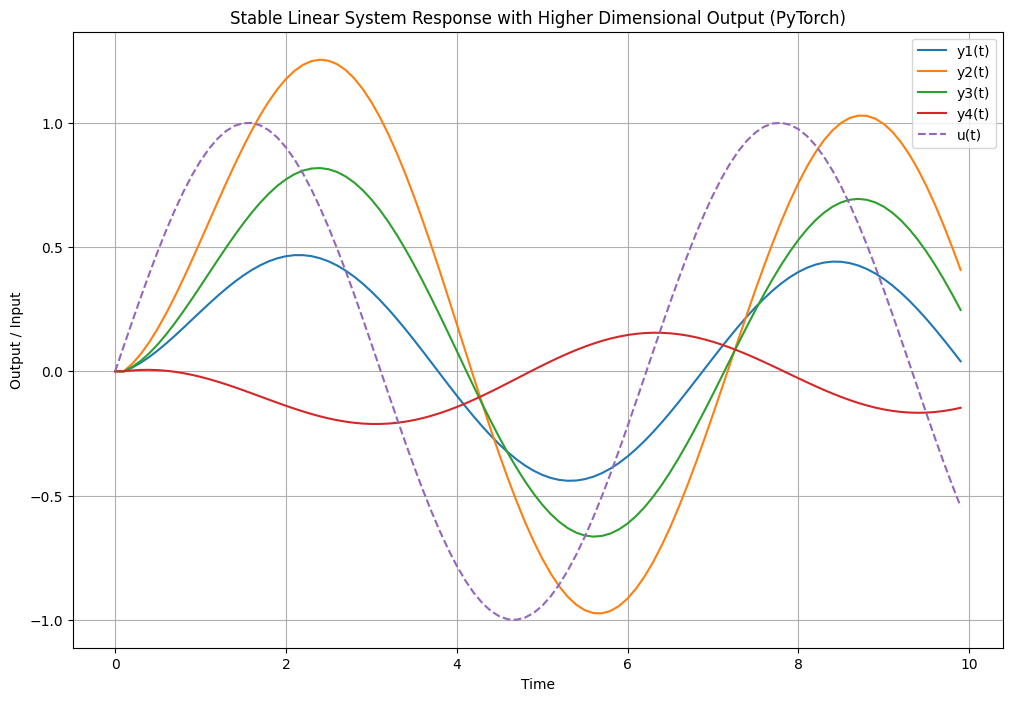

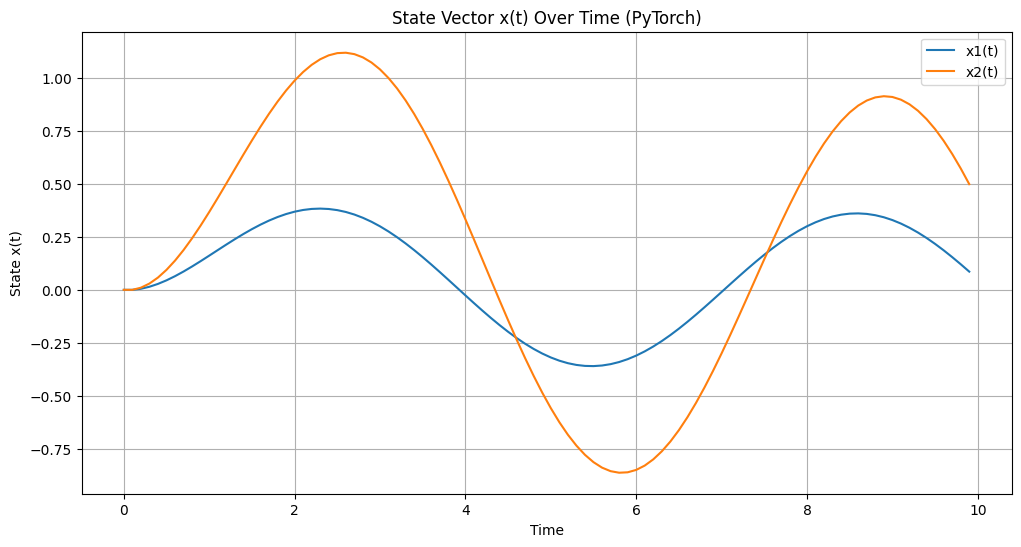

In [63]:
import torch
import matplotlib.pyplot as plt

# System parameters
n = 2  # Dimension of the state vector
m = 4  # Dimension of the output vector (higher than the state vector dimension)
p = 1  # Dimension of the input vector

# Design of a stable A matrix
A = torch.tensor([[-1, 0], [0, -0.5]])  # n x n matrix
B = torch.tensor([[0.5], [1.0]])              # n x p matrix
C = torch.tensor([[1.0, 0.0], 
                  [0.0, 1.0], 
                  [0.5, 0.5],
                  [0.3, -0.3]])               # m x n matrix
D = torch.tensor([[0.1], [0.2], [0.1], [0.05]])  # m x p matrix

# Time step and total number of steps
dt = 0.1  # Time step
T = 100  # Total number of steps

# Initialize state vector
x = torch.zeros(n, T)
y = torch.zeros(m, T)

# Generate u(t), here using a sine wave as an example
u = torch.sin(torch.linspace(0, 10, T)).unsqueeze(0)  # p x T matrix (1 x T)

# Initial state
x[:, 0] = torch.tensor([0.0, 0.0])  # Initial state of x

# Compute x(t) and y(t) using the recursive relation
for t in range(1, T):
    x[:, t] = x[:, t-1] + dt * (A @ x[:, t-1] + B @ u[:, t-1])
    y[:, t] = C @ x[:, t] + D @ u[:, t-1]

# Plot y(t)
plt.figure(figsize=(12, 8))

# Plot each component of y(t)
for i in range(m):
    plt.plot(torch.arange(T) * dt, y[i, :].numpy(), label=f'y{i+1}(t)')

plt.plot(torch.arange(T) * dt, u[0, :].numpy(), label='u(t)', linestyle='--')
plt.title('Stable Linear System Response with Higher Dimensional Output (PyTorch)')
plt.xlabel('Time')
plt.ylabel('Output / Input')
plt.legend()
plt.grid(True)
plt.show()

# Plot x(t)
plt.figure(figsize=(12, 6))

# Plot each component of x(t)
for i in range(n):
    plt.plot(torch.arange(T) * dt, x[i, :].numpy(), label=f'x{i+1}(t)')

plt.title('State Vector x(t) Over Time (PyTorch)')
plt.xlabel('Time')
plt.ylabel('State x(t)')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
print(y.shape)
print(u.shape)

torch.Size([4, 100])
torch.Size([1, 100])


In [65]:
import torch

def Build_Hankel_Matrix(y, i, j):
    """
    Construct the Hankel matrix H_y from y(t).
    """
    y_dim = y.shape[0]
    T = y.shape[1]
    H_y = torch.zeros(2*i*y_dim, j)
    if 2 * i + j > T:
        raise ValueError("The given i and j are too large for the given data.")
    for k in range(2 * i):
        H_y[k*y_dim:(k+1)*y_dim, :] = y[:, k:k+j]
    return H_y

def H_past_Matrix(H_y, i, y_dim):
    """
    Construct the past matrix H_{y,past} from the Hankel matrix H_y.
    """
    return H_y[:i*y_dim, :]

def H_future_Matrix(H_y, i, y_dim):
    """
    Construct the future matrix H_{y,future} from the Hankel matrix H_y.
    """
    return H_y[i*y_dim:2*i*y_dim, :]

def H_past_Matrix_plus(H_y, i, y_dim):
    """
    Construct the past matrix H_{y,past}^+ from the Hankel matrix H_y.
    """
    return H_y[:(i+1)*y_dim, :]

def H_future_Matrix_minus(H_y, i, y_dim):
    """
    Construct the future matrix H_{y,future}^- from the Hankel matrix H_y.
    """
    return H_y[(i+1)*y_dim:(2*i+1)*y_dim, :]

In [66]:
# import torch

# # Define the Orthogonal and Oblique Projections
# def Orthogonal_Complement(A):
#     """
#     Compute the orthogonal complement of matrix A.
#     """
#     print(torch.linalg.cond(A @ A.T + 1e-2 * torch.eye(A.shape[0])))
#     print(A @ A.T)
#     return torch.eye(A.shape[1]) - A.T @ torch.linalg.pinv(A @ A.T) @ A
    

# def Orthogonal_Projection(A, B):
#     """
#     Compute the orthogonal projection of the row vectors of matrix A onto the row vectors of matrix B.
#     """
#     print(torch.linalg.cond(B @ B.T))
#     return A @ B.T @ torch.linalg.pinv(B @ B.T) @ B

# def Oblique_Projection(A, B, C):
#     """
#     Calculate the oblique projection of matrix A onto the subspace spanned by the row vectors of matrix C with the direction of matrix B
#     """
#     B_orth = Orthogonal_Complement(B)
#     P_ABorth = Orthogonal_Projection(A, B_orth)
#     P_CBorth = Orthogonal_Projection(C, B_orth)
#     print(torch.linalg.cond(P_CBorth))
#     return P_ABorth @ torch.linalg.pinv(P_CBorth) @ C


In [84]:
import torch

def truncated_svd_pinv(matrix, threshold=1e-2):
    """
    Compute the pseudoinverse of a matrix using truncated SVD to improve numerical stability.
    """
    U, S, V = torch.svd(matrix)
    
    # 只保留大于阈值的奇异值及其对应的U和V
    valid_indices = S > threshold
    S_truncated = S[valid_indices]
    U_truncated = U[:, valid_indices]
    V_truncated = V[:, valid_indices]
    
    # 计算截断后的S_inv
    S_inv = torch.diag(1.0 / S_truncated)
    
    # 计算伪逆矩阵
    return V_truncated @ S_inv @ U_truncated.T

# Define the Orthogonal and Oblique Projections
def Orthogonal_Complement(A):
    """
    Compute the orthogonal complement of matrix A.
    """
    print("Condition number of A @ A.T (regularized):", torch.linalg.cond(A @ A.T + 1e-2 * torch.eye(A.shape[0])))
    # print("A @ A.T:", A @ A.T)
    return torch.eye(A.shape[1]) - A.T @ truncated_svd_pinv(A @ A.T) @ A

def Orthogonal_Projection(A, B):
    """
    Compute the orthogonal projection of the row vectors of matrix A onto the row vectors of matrix B.
    """
    print("Condition number of B @ B.T:", torch.linalg.cond(B @ B.T))
    return A @ B.T @ truncated_svd_pinv(B @ B.T) @ B

def Oblique_Projection(A, B, C):
    """
    Calculate the oblique projection of matrix A onto the subspace spanned by the row vectors of matrix C with the direction of matrix B.
    """
    B_orth = Orthogonal_Complement(B)
    P_ABorth = Orthogonal_Projection(A, B_orth)
    P_CBorth = Orthogonal_Projection(C, B_orth)
    print("Condition number of P_CBorth:", torch.linalg.cond(P_CBorth))
    return P_ABorth @ truncated_svd_pinv(P_CBorth) @ C

In [85]:
def Subspace_Identification(y, u, i, j):
    H_y = Build_Hankel_Matrix(y, i, j)
    H_u = Build_Hankel_Matrix(u, i, j)
    Y_p = H_past_Matrix(H_y, i, y.shape[0])
    Y_f = H_future_Matrix(H_y, i, y.shape[0])
    U_p = H_past_Matrix(H_u, i, u.shape[0])
    U_f = H_future_Matrix(H_u, i, u.shape[0])
    Y_p_plus = H_past_Matrix_plus(H_y, i, y.shape[0])
    Y_f_minus = H_future_Matrix_minus(H_y, i, y.shape[0])
    U_p_plus = H_past_Matrix_plus(H_u, i, u.shape[0])
    U_f_minus = H_future_Matrix_minus(H_u, i, u.shape[0])
    W_p = torch.cat((Y_p, U_p), 0)
    W_p_plus = torch.cat((Y_p_plus, U_p_plus), 0)

    # Calculate the oblique projection
    O_i = Oblique_Projection(Y_f, U_f, W_p)
    O_i_minus = Oblique_Projection(Y_f_minus, U_f_minus, W_p_plus)

    # Calculate the SVD of the weighted oblique projection
    U, S, VT = torch.svd(O_i)
    print(O_i.shape)

    # Determine the order of the system
    threshold = 1e-3
    r = torch.sum(S > threshold).item()
    U_1 = U[:, :r]
    S_1 = torch.diag(S[:r])
    print(S)

    # Determine Gamma_i and Gamma_{i-1}
    Gamma_i = U_1 @ torch.sqrt(S_1)
    print(Gamma_i.shape)
    Gamma_i_minus = Gamma_i[y.shape[0]:, :]

    # Determine X_i and X_{i+1}
    X_i = torch.linalg.pinv(Gamma_i) @ O_i
    X_i_plus = torch.linalg.pinv(Gamma_i_minus) @ O_i_minus

    # Determine the system matrices
    Y_i = H_y[i*y.shape[0]:(i+1)*y.shape[0], :]
    U_i = H_u[i*u.shape[0]:(i+1)*u.shape[0], :]

    X_plus_Y = torch.cat((X_i_plus, Y_i), 0)
    X_U = torch.cat((X_i, U_i), 0)

    System_Matrices = X_plus_Y @ torch.linalg.pinv(X_U)
    A = System_Matrices[:X_i.shape[0], :X_i.shape[0]]
    B = System_Matrices[:X_i.shape[0], X_i.shape[0]:]
    C = System_Matrices[X_i.shape[0]:, :X_i.shape[0]]
    D = System_Matrices[X_i.shape[0]:, X_i.shape[0]:]

    return A, B, C, D


In [86]:
A_pred, B_pred, C_pred, D_pred = Subspace_Identification(y, u, 14, 20)

Condition number of A @ A.T (regularized): tensor(6784.2017)
Condition number of B @ B.T: tensor(3.2230e+08)
Condition number of B @ B.T: tensor(3.2230e+08)
Condition number of P_CBorth: tensor(1.1975e+08)
Condition number of A @ A.T (regularized): tensor(6305.0083)
Condition number of B @ B.T: tensor(25504820.)
Condition number of B @ B.T: tensor(25504820.)
Condition number of P_CBorth: tensor(1.2981e+08)
torch.Size([56, 20])
tensor([8.6030e+00, 6.5801e-02, 9.3176e-06, 6.2058e-07, 5.1392e-07, 3.8171e-07,
        3.4723e-07, 3.0417e-07, 2.5189e-07, 2.3992e-07, 1.9947e-07, 1.8710e-07,
        1.6641e-07, 1.5035e-07, 1.4373e-07, 1.1612e-07, 1.1043e-07, 9.0299e-08,
        7.1628e-08, 4.3459e-08])
torch.Size([56, 2])


In [87]:
print("A:", A, "\nA_pred:", A_pred)
print("B:", B, "\nB_pred:", B_pred)
print("C:", C, "\nC_pred:", C_pred)
print("D:", D, "\nD_pred:", D_pred)

A: tensor([[-1.0000,  0.0000],
        [ 0.0000, -0.5000]]) 
A_pred: tensor([[ 1.0125,  0.0197],
        [-0.0069,  0.9891]])
B: tensor([[0.5000],
        [1.0000]]) 
B_pred: tensor([[-0.0215],
        [ 0.0083]])
C: tensor([[ 1.0000,  0.0000],
        [ 0.0000,  1.0000],
        [ 0.5000,  0.5000],
        [ 0.3000, -0.3000]]) 
C_pred: tensor([[-0.3545, -0.3409],
        [-1.2105, -0.5075],
        [-0.7758, -0.4137],
        [ 0.2461,  0.0331]])
D: tensor([[0.1000],
        [0.2000],
        [0.1000],
        [0.0500]]) 
D_pred: tensor([[ 0.2935],
        [ 0.5998],
        [ 0.3990],
        [-0.0156]])


Mean Squared Error (MSE) for first 100 steps: 0.08118191361427307
Fit Percentage for first 100 steps: 37.16754913330078%


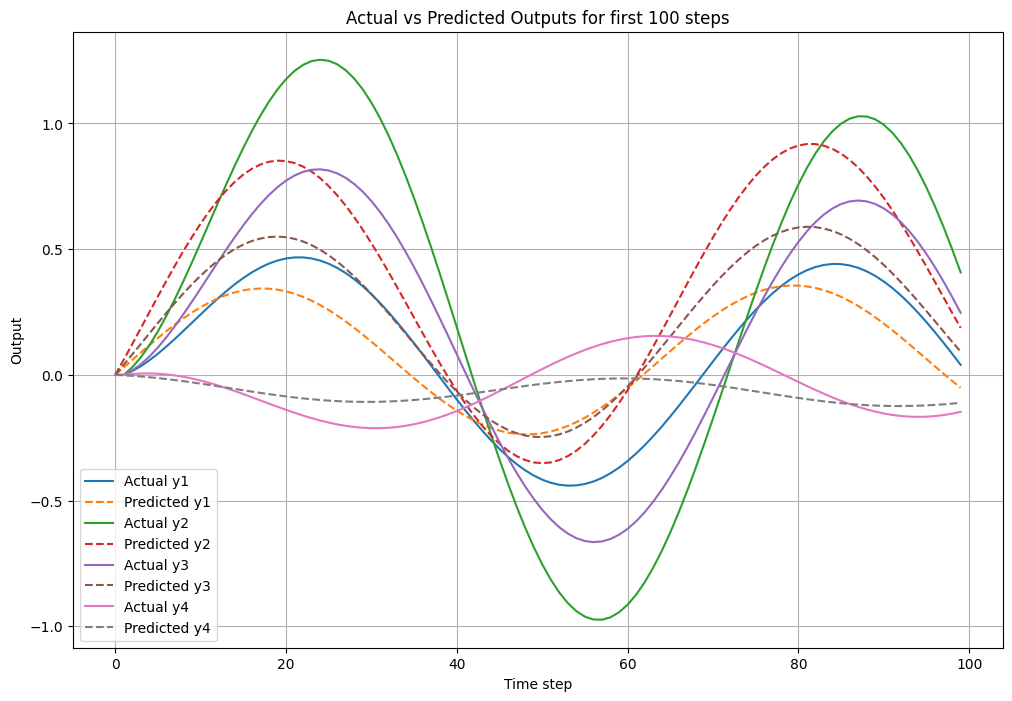

In [88]:
import torch
import matplotlib.pyplot as plt

# Assuming A, B, C, D are your identified matrices
# y and u are your measured output and input data, respectively

# Consider only the first 20 steps
n_steps = 100

# Initialize the state with zeros (or you can use another initial condition)
n_states = A_pred.shape[0]

x_pred = torch.zeros((n_states, n_steps))
y_pred = torch.zeros(y.shape[0], n_steps)

# Estimate x0 by solving y_0 = C * x_0 + D * u_0
x_0_est = torch.zeros(n_states)
x_pred[:, 0] = x_0_est

# Simulate the system for the first 20 steps
for n in range(n_steps - 1):
    x_pred[:, n+1] = A_pred @ x_pred[:, n] + B_pred @ u[:, n]
    y_pred[:, n] = C_pred @ x_pred[:, n] + D_pred @ u[:, n]

# Calculate the last output for the 20th step
y_pred[:, -1] = C_pred @ x_pred[:, -1] + D_pred @ u[:, -1]

# Compute Mean Squared Error (MSE) for the first 20 steps
mse = torch.mean((y[:, :n_steps] - y_pred) ** 2)
print(f'Mean Squared Error (MSE) for first {n_steps} steps: {mse.item()}')

# Compute Fit Percentage for the first 20 steps
y_mean = torch.mean(y[:, :n_steps], dim=1, keepdim=True)
fit = 100 * (1 - torch.norm(y[:, :n_steps] - y_pred) / torch.norm(y[:, :n_steps] - y_mean))
print(f'Fit Percentage for first {n_steps} steps: {fit.item()}%')

# Plot actual vs. predicted outputs for the first 20 steps
plt.figure(figsize=(12, 8))
for i in range(y.shape[0]):
    plt.plot(y[i, :n_steps].numpy(), label=f'Actual y{i+1}')
    plt.plot(y_pred[i, :].detach().numpy(), linestyle='--', label=f'Predicted y{i+1}')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.title(f'Actual vs Predicted Outputs for first {n_steps} steps')
plt.grid(True)
plt.show()

In [89]:
A_pred_2, B_pred_2, C_pred_2, D_pred_2 = Subspace_Identification(y_pred, u, 20, 20)

Condition number of A @ A.T (regularized): tensor(16133.8359)
Condition number of B @ B.T: tensor(1.1240e+08)
Condition number of B @ B.T: tensor(1.1240e+08)
Condition number of P_CBorth: tensor(1.2314e+08)
Condition number of A @ A.T (regularized): tensor(16127.5322)
Condition number of B @ B.T: tensor(53787088.)
Condition number of B @ B.T: tensor(53787088.)
Condition number of P_CBorth: tensor(70092568.)
torch.Size([80, 20])
tensor([1.8073e+01, 1.5511e-06, 1.3276e-06, 9.6005e-07, 8.9330e-07, 8.3988e-07,
        8.1866e-07, 6.5677e-07, 6.3532e-07, 6.0288e-07, 5.6875e-07, 5.1325e-07,
        4.5435e-07, 4.2237e-07, 3.6360e-07, 3.3589e-07, 3.3256e-07, 2.7419e-07,
        2.5186e-07, 2.1060e-07])
torch.Size([80, 1])


In [90]:
# import torch
# import matplotlib.pyplot as plt

# # Assuming A, B, C, D are your identified matrices
# # y and u are your measured output and input data, respectively

# # Consider only the first 20 steps
# n_steps = 100

# # Initialize the state with zeros (or you can use another initial condition)
# n_states = A_pred_2.shape[0]
# x_pred_2 = torch.zeros((n_states, n_steps))
# y_pred_2 = torch.zeros(y.shape[0], n_steps)

# # Estimate x0 by solving y_0 = C * x_0 + D * u_0
# x_0_est = torch.zeros(n_states)
# x_pred_2[:, 0] = x_0_est

# # Simulate the system for the first 20 steps
# for n in range(n_steps - 1):
#     x_pred_2[:, n+1] = A_pred_2 @ x_pred_2[:, n] + B_pred_2 @ u[:, n]
#     y_pred_2[:, n] = C @ x_pred_2[:, n] + D @ u[:, n]

# # Calculate the last output for the 20th step
# y_pred_2[:, -1] = C @ x_pred_2[:, -1] + D @ u[:, -1]

# # Compute Mean Squared Error (MSE) for the first 20 steps
# mse = torch.mean((y_pred[:, :n_steps] - y_pred_2) ** 2)
# print(f'Mean Squared Error (MSE) for first {n_steps} steps: {mse.item()}')

# # Compute Fit Percentage for the first 20 steps
# y_mean = torch.mean(y_pred[:, :n_steps], dim=1, keepdim=True)
# fit = 100 * (1 - torch.norm(y_pred[:, :n_steps] - y_pred_2) / torch.norm(y_pred[:, :n_steps] - y_mean))
# print(f'Fit Percentage for first {n_steps} steps: {fit.item()}%')

# # Plot actual vs. predicted outputs for the first 20 steps
# plt.figure(figsize=(12, 8))
# for i in range(y.shape[0]):
#     plt.plot(y_pred[i, :n_steps].numpy(), label=f'Actual y{i+1}')
#     plt.plot(y_pred_2[i, :].detach().numpy(), linestyle='--', label=f'Predicted y{i+1}')
# plt.xlabel('Time step')
# plt.ylabel('Output')
# plt.legend()
# plt.title(f'Actual vs Predicted Outputs for first {n_steps} steps')
# plt.grid(True)
# plt.show()

In [182]:
# import torch
# import matplotlib.pyplot as plt

# # Assuming A, B, C, D are your identified matrices
# # y and u are your measured output and input data, respectively

# # Consider only the first 20 steps
# n_steps = 100

# # Initialize the state with zeros (or you can use another initial condition)
# n_states = A_pred_2.shape[0]
# x_pred_2 = torch.zeros((n_states, n_steps))
# y_pred_2 = torch.zeros(y.shape[0], n_steps)

# # Estimate x0 by solving y_0 = C * x_0 + D * u_0
# x_0_est = torch.zeros(n_states)
# x_pred_2[:, 0] = x_0_est

# # Simulate the system for the first 20 steps
# for n in range(n_steps - 1):
#     x_pred_2[:, n+1] = A_pred_2 @ x_pred_2[:, n] + B_pred_2 @ u[:, n]
#     y_pred_2[:, n] = C @ x_pred_2[:, n] + D @ u[:, n]

# # Calculate the last output for the 20th step
# y_pred_2[:, -1] = C @ x_pred_2[:, -1] + D @ u[:, -1]

# # Compute Mean Squared Error (MSE) for the first 20 steps
# mse = torch.mean((y[:, :n_steps] - y) ** 2)
# print(f'Mean Squared Error (MSE) for first {n_steps} steps: {mse.item()}')

# # Compute Fit Percentage for the first 20 steps
# y_mean = torch.mean(y[:, :n_steps], dim=1, keepdim=True)
# fit = 100 * (1 - torch.norm(y[:, :n_steps] - y_pred_2) / torch.norm(y_pred[:, :n_steps] - y_mean))
# print(f'Fit Percentage for first {n_steps} steps: {fit.item()}%')

# # Plot actual vs. predicted outputs for the first 20 steps
# plt.figure(figsize=(12, 8))
# for i in range(y.shape[0]):
#     plt.plot(y[i, :n_steps].numpy(), label=f'Actual y{i+1}')
#     plt.plot(y_pred_2[i, :].detach().numpy(), linestyle='--', label=f'Predicted y{i+1}')
# plt.xlabel('Time step')
# plt.ylabel('Output')
# plt.legend()
# plt.title(f'Actual vs Predicted Outputs for first {n_steps} steps')
# plt.grid(True)
# plt.show()

RuntimeError: size mismatch, got 4, 4x2,1